### Google.colab
Only execute this cell when use on google colab platform (colab).

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://github.com/Nak007/RandomSearch">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

Mount with google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/dirve')

# Import other libraries required.
!git clone 'http://github.com/Nak007/RandomSearch.git'

In [50]:
import pandas as pd, numpy as np, sys
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:,.4f}'.format

# scikit-learn library
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (train_test_split as tts, GridSearchCV)
from sklearn.datasets import make_classification

try: sys.path.append('/content/RandomSearch')
except: pass
from RandomSearch import *
from Calibration import get_classweights

Generate a random n-class classification problem. [**`make_classification`**](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html)

In [9]:
X, y = make_classification(n_samples     = 10000, 
                           n_features    = 20, 
                           n_informative = 10, 
                           n_redundant   = 0, 
                           random_state  = 0, 
                           shuffle       = True, 
                           n_classes     = 2, 
                           weights       = [0.7,0.2])

Transform `X` into pandas DataFrame.

In [10]:
X = pd.DataFrame(X, columns=["feature_" + str(n).zfill(2) for n in range(1,X.shape[1]+1)]) 

Split data into **_train_**, and **_test_**

In [11]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.3, shuffle=True, random_state=0)

Create hyper-parameter distribution to be randomized.

In [12]:
n_samples, n_features  = X.shape
param_grids0 = {'max_depth'    : np.arange(10, 1 + np.ceil(np.log2(n_samples))).astype(int),  
                'class_weight' : get_classweights(y=y_train, num=10),
                'max_features' : np.arange(np.ceil(max(np.log2(n_features), 
                                                      np.sqrt(n_features))), 15).astype(int), 
                'criterion'    : ["gini", "entropy"]}

classifier = RandomForestClassifier(n_estimators=300, random_state=0)

Fit **`Modified_RandomizedSearch`**.

In [13]:
RandParams0 = Modified_RandomizedSearch(classifier, param_grids0, n_iter=200, 
                                        random_state=0, n_jobs=-1)
RandParams0.fit(X_train, y_train, [(X_test,y_test)])

**`results`** (attribute) is a dict with keys as column headers and values as columns, that can be imported into a pandas DataFrame. The order of the results corresponds to that in **`params`** (attribute), which is a list of (randomized) parameter settings dicts for all the parameter candidates.

In [14]:
pd.DataFrame(RandParams0.results).head()

,train_f1_score,train_auc,train_accuracy,test0_f1_score,test0_auc,test0_accuracy
0,1.0000,1.0000,1.0000,0.8834,0.9806,0.9450
1,0.9932,0.9999,0.9966,0.8938,0.9781,0.9487
2,1.0000,1.0000,1.0000,0.8900,0.9808,0.9480
3,0.9881,0.9998,0.9940,0.8835,0.9782,0.9440
4,0.9989,1.0000,0.9994,0.8859,0.9797,0.9457


In this example, we are interested in observing the consistency of the model between train and test set. Thus we are using **`find_delta`** to determine the difference of all evaluation metrics.

In [15]:
results0 = pd.DataFrame(find_delta(RandParams0))
results0.head()

,train_f1_score,train_auc,train_accuracy,diff0_f1_score,diff0_auc,diff0_accuracy
0,1.0000,1.0000,1.0000,0.1166,0.0194,0.0550
1,0.9932,0.9999,0.9966,0.0994,0.0219,0.0479
2,1.0000,1.0000,1.0000,0.1100,0.0192,0.0520
3,0.9881,0.9998,0.9940,0.1046,0.0216,0.0500
4,0.9989,1.0000,0.9994,0.1129,0.0203,0.0538


Set the target by finding the $k$ top performers in respective columns.

In [16]:
def find_target(X, alpha=20):
    target = []
    for column in list(X):
        x = X[column].values
        if column.find("diff")>-1: 
            target += [x<=np.percentile(x, alpha)]
        else: target += [x>=np.percentile(x, 100-alpha)]
    return np.vstack(target).T

In [27]:
target0 = find_target(results0).sum(axis=1)==6
print("{:,d} target(s) found.".format(target0.sum()))

2 target(s) found.


Use **`ParameterVisualizer`** to visualize results in a lower dimensional space.

In [28]:
visualize = ParameterVisualizer(mineigval=0.8, option="eigval").fit(results0)

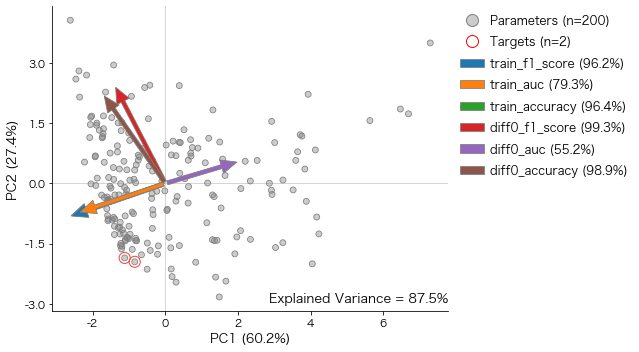

In [29]:
ax = visualize.plot(target=target0, pc_pair=(0,1))

Create parameter grids from selected sets of parameters.

In [30]:
visualize.get_param_grids(np.array(RandParams0.params)[target0])

{'max_features': [11, 12],
 'max_depth': [14],
 'criterion': ['entropy'],
 'class_weight': [{0: 1.0, 1: 1.0}, {0: 1.1889, 1: 2.6341}]}

We can narrow down the search by selecting those parameters that satisfy the defined criteria.

In [38]:
param_grids1 = {'max_depth'    : [14],  
                'class_weight' : get_classweights([1.0000, 1.0000], 
                                                  [1.1889, 2.6341], num=10),
                'max_features' : [11, 12], 
                'criterion'    : ["entropy"]}

In [39]:
RandParams1 = Modified_RandomizedSearch(classifier, param_grids1, n_iter=200, 
                                        random_state=0, n_jobs=-1)
RandParams1.fit(X_train, y_train, [(X_test,y_test)])

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 20 is smaller than n_iter=200. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [40]:
results1 = pd.DataFrame(find_delta(RandParams1))
results1.head()

,train_f1_score,train_auc,train_accuracy,diff0_f1_score,diff0_auc,diff0_accuracy
0,0.9997,1.0000,0.9999,0.1074,0.0187,0.0509
1,1.0000,1.0000,1.0000,0.1085,0.0191,0.0513
2,1.0000,1.0000,1.0000,0.1110,0.0188,0.0523
3,1.0000,1.0000,1.0000,0.1142,0.0187,0.0540
4,1.0000,1.0000,1.0000,0.1061,0.0187,0.0503


In [41]:
target1 = find_target(results1).sum(axis=1)==6
print("{:,d} target(s) found.".format(target1.sum()))

1 target(s) found.


In [42]:
visualize = ParameterVisualizer(mineigval=0.8, option="eigval").fit(results1)

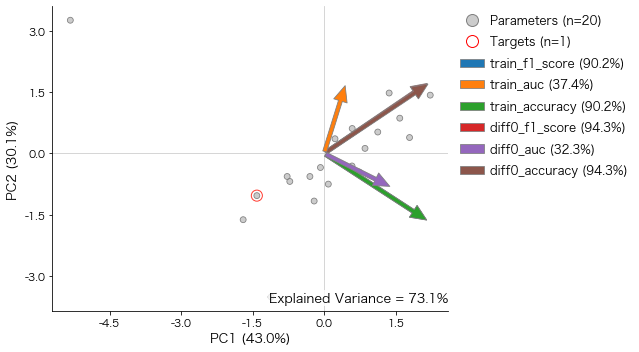

In [45]:
ax = visualize.plot(target=target1, pc_pair=(0,1))

In [46]:
visualize.get_param_grids(np.array(RandParams1.params)[target1])

{'max_features': [11],
 'max_depth': [14],
 'criterion': ['entropy'],
 'class_weight': [{0: 1.042, 1: 1.3631}]}

In [47]:
pd.DataFrame(RandParams1.results)[target1]

,train_f1_score,train_auc,train_accuracy,test0_f1_score,test0_auc,test0_accuracy
4,1.0000,1.0000,1.0000,0.8939,0.9813,0.9497


Use **`PlotGridSearch`** to visualize results from [**`GridSearchCV`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [109]:
scoring = {'F1-Score': make_scorer(f1_score), 
           'AUC'     : make_scorer(roc_auc_score),
           'Accuracy': make_scorer(accuracy_score)}

In [110]:
estimator = RandomForestClassifier(n_estimators=300, random_state=0, 
                                   max_features=11, criterion="entropy", 
                                   class_weight={0: 1.042, 1: 1.3631})

In [124]:
gs = GridSearchCV(estimator, param_grid={'max_depth' : np.arange(5, 16)}, 
                  scoring=scoring, refit=False, return_train_score=True, 
                  n_jobs=-1, cv=3).fit(X_train, y_train)

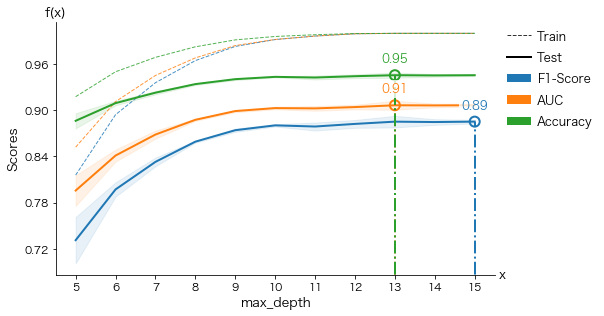

In [127]:
ax = PlotGridSearch(gs, decimal=2)